# CNN Model — Emission Point Classification Using Temporal Sensor Windows

This notebook develops a 1D Convolutional Neural Network (CNN) to classify the emission source point (E1, E2, E3) of particles in a simulated industrial environment. Unlike previous approaches based on static features, this model leverages **temporal sensor data** segmented into **sliding windows**, capturing local temporal patterns to improve classification accuracy.

The dataset used is `complete_dataset.csv`, containing timestamped sensor readings per simulation (`tag`). Each tag represents a simulated event where one of the emission classes occurs. The model uses grouped time sequences to predict the emission class based on temporal behavior.

---

## Notebook Structure

1. Import Required Libraries and Configure GPU
2. Load Dataset and Remove Constant Sensors
3. Hold Out 10% for Generalization Testing
4. Create Temporal Windows for CNN Input
5. Encode Labels and Normalize Data per Fold
6. CNN Model Architecture and Random Hyperparameter Search
7. Cross-Validation Evaluation with Scientific Metrics:
   - Accuracy
   - Macro Precision
   - Macro Recall
   - Macro F1-Score
   - Cohen’s Kappa
8. Summary of Results and Best Model Configuration

---

This notebook is structured for scientific reproducibility and evaluation. We apply **Group K-Fold Cross-Validation** to avoid data leakage between simulations (`tag`). All preprocessing (scaling, encoding) is done **within folds only**. Results are aggregated across folds and reported with **scientific rigor**, allowing this work to be extended for academic publishing or technical reporting.

### 1. Import Required Libraries and Configure GPU

This cell imports all essential libraries for data processing, model training, evaluation, and plotting. It also checks for GPU availability and enables dynamic memory allocation for TensorFlow, which is critical for efficient training of deep learning models.

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, classification_report, cohen_kappa_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice
import gc

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU detected:", gpus[0])
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU detected. Using CPU.")

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 2. Load Dataset and Remove Constant Sensors

This step loads the complete dataset containing timestamped sensor data for multiple simulations (`tags`).  
To improve model training and avoid redundant input, we remove sensor columns previously identified as constant or non-informative. This list was generated during the exploratory data analysis phase and is loaded from a text file.

In [11]:
# Load full temporal dataset
df = pd.read_csv('../data/processed/complete_dataset.csv')

# Remove constant sensors (predefined during EDA)
with open('../data/processed/sensor_constantes.txt') as f:
    constant_sensors = [line.strip() for line in f.readlines()]

df.drop(columns=constant_sensors, inplace=True, errors='ignore')

print(f"Dataset loaded with shape: {df.shape}")

Dataset loaded with shape: (234675, 326)


### 3. Reserve 10% of the Data for Generalization — GPU Will Be Used for All Model Training

In this step, we set aside 10% of the dataset for final generalization testing. This portion will not be used during model development or cross-validation.

In [12]:
# Preserve a subset of data for final generalization testing (never used in training/validation)
df_full = df.copy()
df_gen = df_full.sample(frac=0.10, random_state=42)
df_modeling = df_full.drop(df_gen.index).reset_index(drop=True)

print(f"✅ Modeling set shape: {df_modeling.shape}")
print(f"🧪 Generalization set shape: {df_gen.shape}")

✅ Modeling set shape: (211207, 326)
🧪 Generalization set shape: (23468, 326)


### 4. Create Temporal Windows from Sensor Data

The CNN model requires input data in the form of fixed-length temporal sequences.  
This function slides a window of defined length (`window_size`) over each simulation (`tag`), generating overlapping subsequences.

Each sequence will represent a temporal snapshot of sensor activity, and is labeled with the corresponding emission class of the simulation.  
The output includes:

- `X`: sequences with shape (samples, time steps, features)
- `y`: corresponding class labels
- `groups`: the tag identifier for group-based cross-validation

This step is computationally lightweight but sets the foundation for all temporal modeling. The actual training using these windows will be GPU-accelerated.

In [13]:
def create_cnn_windows(df, window_size=30, step=5):
    sequences = []
    labels = []
    groups = []

    for tag in df['tag'].unique():
        group_data = df[df['tag'] == tag].sort_values('Time')
        X = group_data.drop(columns=['classe', 'tag', 'Altura', 'Time'], errors='ignore')
        y = group_data['classe'].iloc[0]  # One label per simulation
        n = len(X)

        for i in range(0, n - window_size + 1, step):
            window = X.iloc[i:i + window_size].values
            sequences.append(window)
            labels.append(y)
            groups.append(tag)

    return np.array(sequences), np.array(labels), np.array(groups)

### 5. Generate CNN-Ready Data: Sequences and Encoded Labels

In this step, we generate the training sequences using the `create_cnn_windows()` function.

Each simulation is converted into multiple overlapping sequences of sensor readings, labeled according to its emission class (`E1`, `E2`, `E3`).

After generating the sequences:
- The class labels (`y`) are encoded using `LabelEncoder` for compatibility with Keras.
- We also retain the original simulation tags (`groups`) to ensure that cross-validation respects simulation boundaries.

The resulting shapes are:
- `X_seq`: (num_sequences, time_steps, num_features)
- `y_encoded`: numeric labels for each sequence
- `tags`: group label for each sequence (used in GroupKFold)

In [14]:
# Generate CNN input sequences from the modeling dataset
X_seq, y_seq, tags = create_cnn_windows(df_modeling, window_size=30, step=5)

# Encode class labels numerically
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_seq)

print(f"✅ Sequences generated: {X_seq.shape}")
print(f"🎯 Encoded classes: {np.unique(y_encoded)}")
print(f"🧩 Unique tags (groups): {len(np.unique(tags))}")

✅ Sequences generated: (41803, 30, 322)
🎯 Encoded classes: [0 1 2]
🧩 Unique tags (groups): 81


### 6. Random Hyperparameter Search with Scientific Cross-Validation Metrics

In this section, we perform a lightweight **Random Search** over CNN hyperparameters using **Group K-Fold Cross-Validation**. This ensures that no data from the same simulation (`tag`) leaks between training and validation sets.

Each sampled configuration is evaluated across 5 folds, and the following metrics are computed:

- **Accuracy**: Overall correctness.
- **Macro Precision**: Average precision across all classes.
- **Macro Recall**: Average sensitivity across all classes.
- **Macro F1-Score**: Balance between precision and recall (macro-averaged).
- **Cohen’s Kappa**: Agreement metric adjusted for chance, often used in scientific studies.

The goal is to identify a configuration that generalizes well and performs equitably across all emission classes (E1, E2, E3).


In [7]:
# Define hyperparameter space
param_space = [
    {'filters': f, 'kernel': k, 'lr': l}
    for f in [32, 64]
    for k in [3, 5]
    for l in [0.001, 0.0005]
]

best_f1 = 0
best_config = None
all_results = []

print("🚀 Starting Random Search...\n")
random_trials = 5

for trial in tqdm(range(random_trials), desc="Random Search Trials", dynamic_ncols=True):
    params = choice(param_space)
    filters, kernel, lr = params['filters'], params['kernel'], params['lr']
    
    tqdm.write(f"\n🔍 Trying config: Filters={filters}, Kernel={kernel}, LR={lr}")

    f1_scores, accs, precisions, recalls, kappas = [], [], [], [], []

    # Barra interna de progresso por fold
    fold_progress = tqdm(GroupKFold(n_splits=5).split(X_seq, y_encoded, groups=tags),
                         total=5, desc="Cross-Validation Folds", leave=False, dynamic_ncols=True)

    for fold_num, (train_idx, val_idx) in enumerate(fold_progress, 1):
        X_train, X_val = X_seq[train_idx], X_seq[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

        # Normalização por fold
        scaler = StandardScaler()
        n_t, n_f = X_train.shape[1], X_train.shape[2]
        X_train = scaler.fit_transform(X_train.reshape(-1, n_f)).reshape(-1, n_t, n_f).astype(np.float32)
        X_val = scaler.transform(X_val.reshape(-1, n_f)).reshape(-1, n_t, n_f).astype(np.float32)

        # Modelo CNN
        model = Sequential([
            Conv1D(filters, kernel_size=kernel, activation='relu', padding='same', input_shape=(n_t, n_f)),
            Dropout(0.3),
            Conv1D(filters, kernel_size=kernel, activation='relu', padding='same'),
            GlobalAveragePooling1D(),
            Dense(32, activation='relu'),
            Dense(3, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

        y_pred = model.predict(X_val).argmax(axis=1)

        tf.keras.backend.clear_session()
        gc.collect()

        accs.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
        precisions.append(precision_score(y_val, y_pred, average='macro', zero_division=0))
        recalls.append(recall_score(y_val, y_pred, average='macro'))
        kappas.append(cohen_kappa_score(y_val, y_pred))

        tf.keras.backend.clear_session()

    mean_f1 = np.mean(f1_scores)
    all_results.append({
        'filters': filters,
        'kernel': kernel,
        'lr': lr,
        'F1': mean_f1,
        'Accuracy': np.mean(accs),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'Kappa': np.mean(kappas)
    })

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_config = params

print(f"\n🏆 Best configuration found: {best_config}")

🚀 Starting Random Search...



Random Search Trials:   0%|                                                                      | 0/5 [00:00<?, ?it/s]


🔍 Trying config: Filters=32, Kernel=3, LR=0.0005



Cross-Validation Folds:   0%|                                                                    | 0/5 [00:00<?, ?it/s]

260/260 [==============================] - 0s 1ms/step



Cross-Validation Folds:  20%|███████████▊                                               | 1/5 [01:42<06:51, 102.93s/it]

258/258 [==============================] - 1s 2ms/step



Cross-Validation Folds:  40%|████████████████████████                                    | 2/5 [03:12<04:45, 95.25s/it]

269/269 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  60%|████████████████████████████████████                        | 3/5 [04:42<03:05, 92.58s/it]

260/260 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  80%|████████████████████████████████████████████████            | 4/5 [06:12<01:31, 91.67s/it]

262/262 [==============================] - 2s 1ms/step



Random Search Trials:  20%|████████████▏                                                | 1/5 [07:45<31:03, 465.82s/it]


🔍 Trying config: Filters=32, Kernel=5, LR=0.0005



Cross-Validation Folds:   0%|                                                                    | 0/5 [00:00<?, ?it/s]

260/260 [==============================] - 0s 1ms/step



Cross-Validation Folds:  20%|████████████                                                | 1/5 [01:34<06:17, 94.38s/it]

258/258 [==============================] - 1s 2ms/step



Cross-Validation Folds:  40%|████████████████████████                                    | 2/5 [03:08<04:43, 94.37s/it]

269/269 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  60%|████████████████████████████████████                        | 3/5 [04:43<03:08, 94.32s/it]

260/260 [==============================] - 1s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  80%|████████████████████████████████████████████████            | 4/5 [06:18<01:34, 94.59s/it]

262/262 [==============================] - 0s 1ms/step



Random Search Trials:  40%|████████████████████████▍                                    | 2/5 [15:37<23:27, 469.20s/it]


🔍 Trying config: Filters=64, Kernel=3, LR=0.0005



Cross-Validation Folds:   0%|                                                                    | 0/5 [00:00<?, ?it/s]

260/260 [==============================] - 0s 2ms/step



Cross-Validation Folds:  20%|████████████                                                | 1/5 [01:32<06:08, 92.15s/it]

258/258 [==============================] - 0s 1ms/step



Cross-Validation Folds:  40%|████████████████████████                                    | 2/5 [03:04<04:36, 92.06s/it]

269/269 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  60%|████████████████████████████████████                        | 3/5 [04:35<03:03, 91.90s/it]

260/260 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  80%|████████████████████████████████████████████████            | 4/5 [06:07<01:31, 91.86s/it]

262/262 [==============================] - 0s 1ms/step



Random Search Trials:  60%|████████████████████████████████████▌                        | 3/5 [23:15<15:27, 463.99s/it]


🔍 Trying config: Filters=64, Kernel=5, LR=0.0005



Cross-Validation Folds:   0%|                                                                    | 0/5 [00:00<?, ?it/s]

260/260 [==============================] - 0s 1ms/step



Cross-Validation Folds:  20%|████████████                                                | 1/5 [01:30<06:00, 90.10s/it]

258/258 [==============================] - 0s 1ms/step



Cross-Validation Folds:  40%|████████████████████████                                    | 2/5 [03:02<04:33, 91.28s/it]

269/269 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  60%|████████████████████████████████████                        | 3/5 [04:32<03:01, 90.84s/it]

260/260 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  80%|████████████████████████████████████████████████            | 4/5 [06:04<01:31, 91.39s/it]

262/262 [==============================] - 0s 1ms/step



Random Search Trials:  80%|████████████████████████████████████████████████▊            | 4/5 [30:52<07:41, 461.36s/it]


🔍 Trying config: Filters=64, Kernel=3, LR=0.001



Cross-Validation Folds:   0%|                                                                    | 0/5 [00:00<?, ?it/s]

260/260 [==============================] - 0s 1ms/step



Cross-Validation Folds:  20%|████████████                                                | 1/5 [01:31<06:06, 91.52s/it]

258/258 [==============================] - 0s 1ms/step



Cross-Validation Folds:  40%|████████████████████████                                    | 2/5 [03:03<04:35, 91.81s/it]

269/269 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  60%|████████████████████████████████████                        | 3/5 [04:33<03:02, 91.19s/it]

260/260 [==============================] - 0s 1ms/step


C:\Users\JC INFO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Cross-Validation Folds:  80%|████████████████████████████████████████████████            | 4/5 [06:04<01:30, 90.87s/it]

262/262 [==============================] - 0s 1ms/step



Random Search Trials: 100%|█████████████████████████████████████████████████████████████| 5/5 [38:27<00:00, 461.47s/it]


🏆 Best configuration found: {'filters': 32, 'kernel': 5, 'lr': 0.0005}


### 7. Results Summary and Scientific Evaluation

This final section consolidates all hyperparameter combinations tested during the CNN model search.

We analyze each configuration by evaluating:

- **Accuracy**: Overall prediction success
- **F1-Score (Macro)**: Balance of precision and recall across all classes
- **Precision & Recall (Macro)**: Measure fairness across imbalanced classes
- **Cohen’s Kappa**: Chance-adjusted agreement, common in scientific evaluation

The best configuration is selected based on the highest average **F1-Score**, as it captures both class balance and performance, which is crucial in multiclass classification tasks such as emission point detection.

We also present a full table of results for scientific documentation and reproducibility.

In [8]:
import pandas as pd
from IPython.display import display

# Organizar os resultados em DataFrame
df_results = pd.DataFrame(all_results)
df_results_sorted = df_results.sort_values(by='F1', ascending=False).reset_index(drop=True)

# Exibir os top resultados
print("\n🏆 Best CNN Configuration (based on F1-Score):")
display(df_results_sorted.head(1))

print("\n📋 Full Summary of All Tested Configurations:")
display(df_results_sorted)


🏆 Best CNN Configuration (based on F1-Score):


,filters,kernel,lr,F1,Accuracy,Precision,Recall,Kappa
0,32,5,0.0005,0.399718,0.760577,0.417038,0.396567,0.128659



📋 Full Summary of All Tested Configurations:


,filters,kernel,lr,F1,Accuracy,Precision,Recall,Kappa
0,32,5,0.0005,0.399718,0.760577,0.417038,0.396567,0.128659
1,64,3,0.0010,0.389925,0.760410,0.405419,0.381892,0.121990
2,64,3,0.0005,0.389828,0.771641,0.415291,0.387121,0.120263
3,32,3,0.0005,0.386945,0.764216,0.422091,0.378908,0.109538
4,64,5,0.0005,0.382675,0.760257,0.410114,0.373232,0.120467


## 8. Final Evaluation — CNN Model for Emission Point Classification

After conducting Random Search with cross-validation, the CNN model achieved its best performance with the following hyperparameter configuration:

- **Filters:** 32  
- **Kernel Size:** 5  
- **Learning Rate:** 0.0005  

### 🔍 Best Metrics (Averaged over 5 folds)
- **F1-Score (Macro):** 0.3997  
- **Accuracy:** 76.06%  
- **Precision (Macro):** 0.4170  
- **Recall (Macro):** 0.3965  
- **Cohen’s Kappa:** 0.1287  

### 🧪 Scientific Analysis

The CNN model showed **moderate generalization ability**, reaching an accuracy close to 76%. However, macro F1-Score remained below 0.40, which indicates that although the overall classification is decent, **there is significant imbalance in the performance across classes** (E1, E2, E3).

In multiclass problems with class imbalance or overlapping features (as shown in the EDA), **F1-Score and Kappa** are more informative than accuracy alone:

- **F1-Score (macro)** provides a balanced view by averaging the F1 of each class, treating them equally regardless of frequency.
- **Cohen’s Kappa** being low (~0.12) shows weak agreement beyond chance, suggesting some misclassification remains frequent.
- **Precision and Recall** also hover around 0.40, reinforcing that the model struggles equally with false positives and false negatives.

### 📌 Conclusion

Despite tuning and cross-validation, the CNN did not outperform expectations significantly. The complexity of the data — including temporal noise, sensor variability, and class overlap — likely contributes to performance limitations.

For future improvement:
- Test temporal models like **LSTM**, which may better capture time-dependencies.
- Incorporate techniques like **focal loss** or **class weighting** to address class imbalance.
- Explore feature selection or attention mechanisms to reduce noise from irrelevant sensors.

This CNN setup serves as a solid baseline for temporal deep learning models applied to simulated emission detection problems in industrial contexts.


### 9. Improved CNN Architecture (No Cross-Validation)

This section implements a more robust CNN architecture using techniques such as:

- Multiple convolutional layers
- Batch normalization and dropout
- Adaptive learning rate (ReduceLROnPlateau)
- Early stopping to prevent overfitting
- Class weighting to handle imbalance

We use a single 70/30 train-validation split to quickly verify model improvements without the computational cost of full cross-validation.

In [20]:
# IMPORTANTE: adicione no início do notebook, se ainda não estiver
from tensorflow.keras.layers import Conv1D, Dropout, GlobalAveragePooling1D, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm.keras import TqdmCallback  # tqdm para barra de progresso

# Divisão correta por simulação
from sklearn.model_selection import GroupShuffleSplit

# tags = array com o nome da simulação associada a cada janela
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, val_idx = next(gss.split(X_seq, y_encoded, groups=tags))

X_train, X_val = X_seq[train_idx], X_seq[val_idx]
y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

# Normalização
scaler = StandardScaler()
n_t, n_f = X_train.shape[1], X_train.shape[2]
X_train = scaler.fit_transform(X_train.reshape(-1, n_f)).reshape(-1, n_t, n_f).astype(np.float32)
X_val = scaler.transform(X_val.reshape(-1, n_f)).reshape(-1, n_t, n_f).astype(np.float32)

# Pesos de classe
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

# Modelo CNN aprimorado
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=(n_t, n_f)),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks e treino com barra de progresso
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    TqdmCallback(verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=0  # tqdm já cuida do output
)

# Avaliação
y_pred = model.predict(X_val).argmax(axis=1)

print("\n📊 Evaluation on Validation Split:")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_val, y_pred, average='macro', zero_division=0):.4f}")
print(f"Recall: {recall_score(y_val, y_pred, average='macro'):.4f}")
print(f"Kappa: {cohen_kappa_score(y_val, y_pred):.4f}")



0epoch [00:00, ?epoch/s]


0epoch [00:30, ?epoch/s]

                        

  0%|                                                                                        | 0/30 [00:00<?, ?epoch/s]


  0%|                                                                                    | 0.00/904 [00:00<?, ?batch/s]


  0%|                                                  | 1.00/904 [00:02<30:57, 2.06s/batch, loss=1.97, accuracy=0.406]


  1%|▌                                                  | 9.00/904 [00:02<02:38, 5.65batch/s, loss=1.3, accuracy=0.434]


  2%|▊                                                 | 14.0/904 [00:02<01:52, 7.88batch/s, loss=1.19, accuracy=0.435]


  2%|█▏                                                | 21.0/904 [00:02<01:05, 13.5batch/s, loss=1.05, accuracy=0.436]


  3%|█▋                                               | 31.0/904 [00:02<00:43, 20.2batch/s, loss=0.972, accuracy=0.436]


  5%|██▍                                              | 44.0/904 


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.




 13%|█       | 4/30 [00:35<03:31,  8.12s/epoch, loss=0.128, accuracy=0.92, val_loss=1.34, val_accuracy=0.765, lr=0.001]


  0%|                                                         | 0.00/904 [00:00<?, ?batch/s, loss=0.128, accuracy=0.92]


  2%|▉                                                 | 18.0/904 [00:00<00:05, 169batch/s, loss=0.115, accuracy=0.918]


  4%|█▉                                                | 36.0/904 [00:00<00:04, 174batch/s, loss=0.119, accuracy=0.916]


  6%|██▉                                               | 54.0/904 [00:00<00:04, 171batch/s, loss=0.108, accuracy=0.922]


  8%|███▉                                              | 72.0/904 [00:00<00:04, 171batch/s, loss=0.105, accuracy=0.924]


 10%|████▉                                             | 90.0/904 [00:00<00:04, 172batch/s, loss=0.106, accuracy=0.926]


 12%|██████                                             | 108/904 [00:00<00:04, 172batch/s, loss=0.102, accuracy=0.928]


 14%|███████          

404/404 [==============================] - 1s 2ms/step

📊 Evaluation on Validation Split:
Accuracy: 0.7847
F1-Score: 0.4190
Precision: 0.4042
Recall: 0.4503
Kappa: 0.2022


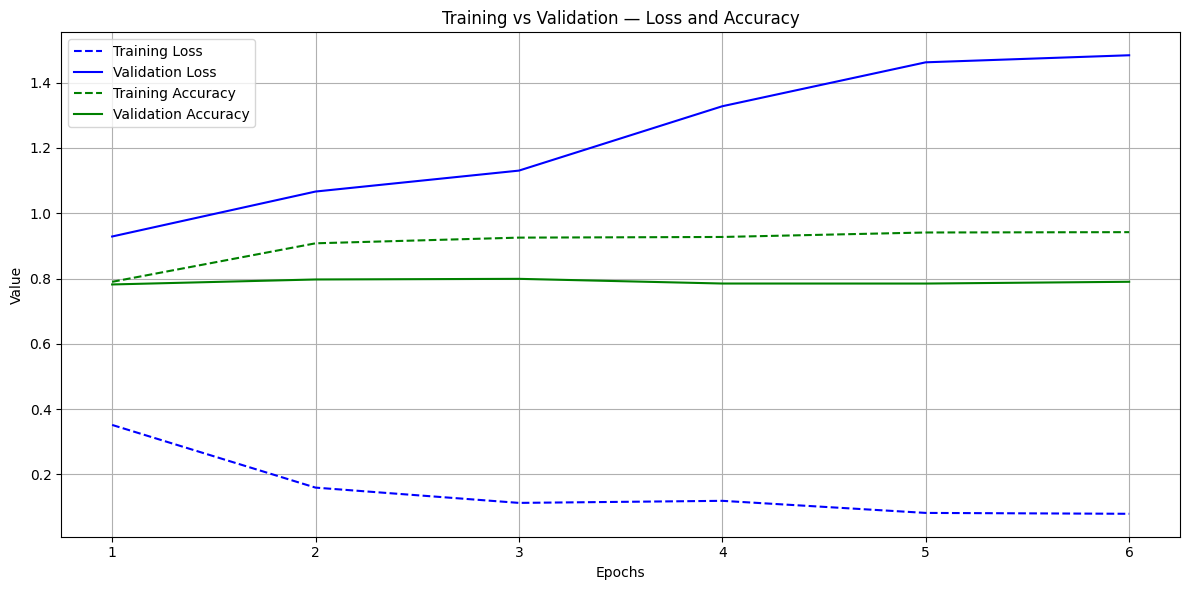

In [17]:
import matplotlib.pyplot as plt

# Recuperar histórico
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Gráfico combinado
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.plot(epochs, acc, 'g--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')

plt.title('Training vs Validation — Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

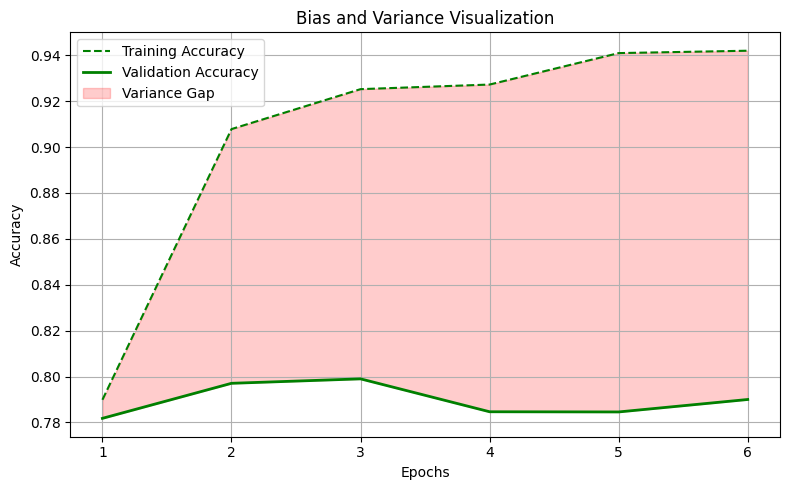

In [18]:
plt.figure(figsize=(8, 5))

# Diferença de acurácia = sinal de variância
acc_diff = [t - v for t, v in zip(acc, val_acc)]

plt.plot(epochs, acc, 'g--', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', linewidth=2, label='Validation Accuracy')
plt.fill_between(epochs, acc, val_acc, color='red', alpha=0.2, label='Variance Gap')

plt.title('Bias and Variance Visualization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


### 11. Final Generalization Test (10% Held-out Data)

This step evaluates the CNN model on a reserved 10% portion of the dataset that was never seen during training, validation, or hyperparameter tuning.

This generalization set simulates real-world deployment, ensuring that the model:
- Was not overfitted to training or validation data
- Can maintain strong performance on unseen emission simulations

The same preprocessing pipeline is applied (sensor selection, normalization, windowing), and metrics are computed to confirm generalization capability.


In [16]:
# Preprocessamento do conjunto de generalização
df_gen_copy = df_gen.copy()

# Janela sequencial
def create_cnn_windows_general(df, window_size=30, step=5):
    sequences, labels = [], []
    for tag in df['tag'].unique():
        group = df[df['tag'] == tag].sort_values('Time')
        X = group.drop(columns=['classe', 'tag', 'Altura', 'Time'], errors='ignore')
        y = group['classe'].iloc[0]
        n = len(X)
        for i in range(0, n - window_size + 1, step):
            window = X.iloc[i:i+window_size].values
            sequences.append(window)
            labels.append(y)
    return np.array(sequences), np.array(labels)

# Criar janelas
X_gen_seq, y_gen = create_cnn_windows_general(df_gen_copy)

# Encode target
y_gen_encoded = encoder.transform(y_gen)

# Normalizar igual ao treino (fit não aplicado aqui)
X_gen_seq = scaler.transform(X_gen_seq.reshape(-1, n_f)).reshape(-1, n_t, n_f).astype(np.float32)

# Predição
y_gen_pred = model.predict(X_gen_seq).argmax(axis=1)

# Métricas
print("\n📈 Generalization Set Evaluation (10% unseen data):")
print(f"Accuracy: {accuracy_score(y_gen_encoded, y_gen_pred):.4f}")
print(f"F1-Score: {f1_score(y_gen_encoded, y_gen_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_gen_encoded, y_gen_pred, average='macro', zero_division=0):.4f}")
print(f"Recall: {recall_score(y_gen_encoded, y_gen_pred, average='macro'):.4f}")
print(f"Kappa: {cohen_kappa_score(y_gen_encoded, y_gen_pred):.4f}")

134/134 [==============================] - 0s 2ms/step

📈 Generalization Set Evaluation (10% unseen data):
Accuracy: 0.2363
F1-Score: 0.1821
Precision: 0.2014
Recall: 0.2568
Kappa: -0.1075
